In [1]:
import Pkg, Revise
using DrWatson
@quickactivate "sst-mot-analysis"

using GH19, TMI
using PythonPlot, PythonCall, CondaPkg

import DrWatson: datadir, srcdir

using NaNStatistics, Interpolations, 
      Statistics, LinearAlgebra

const mtpl = pyimport("matplotlib");
const cartopy = pyimport("cartopy");
const matplotlib = pyimport("matplotlib");
const sns = pyimport("seaborn");
const cm = pyimport("cmocean.cm")

mtpl.rcParams["figure.dpi"] = 100
ccrs = cartopy.crs

custom_style = Dict("text.color" => "black")
sns.set_theme(context="notebook", style="ticks", palette = "colorblind", rc=custom_style)
ccrs = cartopy.crs;
cfeature = cartopy.feature

/Users/anthonymeza/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/Documents/GitHub/sst-mot-analysis/.CondaPkg/.pixi/envs/default/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


Python: <module 'cartopy.feature' from '/Users/anthonymeza/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/Documents/GitHub/sst-mot-analysis/.CondaPkg/.pixi/envs/default/lib/python3.12/site-packages/cartopy/feature/__init__.py'>

In [2]:
include(srcdir("load_GH19.jl"))
include(srcdir("decompose_discrete.jl"))
include(srcdir("blocksum.jl"))
include(srcdir("IntersectionFunctions.jl"))

plot_map_and_zonal (generic function with 1 method)

In [3]:
function get_area_normalized_volume_filled_bc(TMIversion,Alu,γ)
    volume = volumefilled(TMIversion,Alu,γ); 
    volume = (10 .^ volume.tracer)
    volume = BoundaryCondition(volume,(γ.lon,γ.lat),γ.depth[1],3,1,γ.wet[:, :, 1],:V,"volume filled by surface gridcell per area","m³/m²")
    return 1 * volume
end

function get_volume_filled_bc(volume_normalized, γ, areao)
    volume = volume_normalized.tracer .* Float64.(areao.tracer)
    volume = BoundaryCondition(volume,(γ.lon,γ.lat),γ.depth[1],3,1,volume_normalized.wet,:V,"volume filled by surface gridcell","m³")
    return 1 * volume
end

function get_MOT_and_SST(TMIfile::String, γ::Grid)
    θ̄ = readfield(TMIfile, "θ", γ); #true mean
    volume = cellvolume(γ).tracer 
    θ̄_MOT = nansum(θ̄.tracer .* volume) / nansum(volume)
    θ̄_SST = getsurfaceboundary(θ̄);

    return θ̄_MOT, θ̄_SST
end

function get_MOT_and_SST(θ̄::Field, γ::Grid)
    volume = cellvolume(γ).tracer 
    θ̄_MOT = nansum(θ̄.tracer .* volume) / nansum(volume)
    θ̄_SST = getsurfaceboundary(θ̄);

    return θ̄_MOT, θ̄_SST
end

surfacecellarea(γ) = cellarea(γ)

surfacecellarea (generic function with 1 method)

In [4]:
###### LOAD LGM ###########
TMI_version = "LGM_90x45x33_G14";
A, Alu, γ_lgm, TMIfile, L, B = config(TMI_version); println(sum(cellvolume(γ_lgm))) 
TMIfile = TMI.pkgdatadir("TMI_"*TMI_version*".nc")

volume_lgm_normalized = get_area_normalized_volume_filled_bc(TMIversion,Alu,γ_lgm)

volume_lgm = get_volume_filled_bc(volume_lgm_normalized, γ_lgm, surfacecellarea(γ_lgm))

θ̄_LGM_MOT, θ̄_LGM_SST = get_MOT_and_SST(TMIfile, γ_lgm);

###### LOAD PREINDUSTRIAL ###########
TMI_version = GH19.TMIversion();
A, Alu, γ_mod, TMIfile, L, B = config(TMI_version); 
TMIfile = TMI.pkgdatadir("TMI_"*TMI_version*".nc")

volume_mod_normalized_fine = get_area_normalized_volume_filled_bc(TMIversion,Alu,γ_mod)

volume_mod_fine = get_volume_filled_bc(volume_mod_normalized_fine, γ_mod, surfacecellarea(γ_mod))
θ̄GH19 = load_GH19_equillibrium()
θ̄_mod_MOT, θ̄_mod_SST_fine = get_MOT_and_SST(θ̄GH19, γ_mod);

A
  0.230906 seconds (676.10 k allocations: 69.775 MiB, 5.15% gc time, 85.30% compilation time)
Alu
  0.587810 seconds (586.66 k allocations: 506.638 MiB, 1.20% gc time, 12.15% compilation time)
L=
  0.084706 seconds (83.88 k allocations: 4.452 MiB, 97.14% compilation time)
B=
  0.019168 seconds (16.48 k allocations: 871.125 KiB, 90.61% compilation time)
1.4442375457929354e18
A
  0.044333 seconds (5.23 k allocations: 127.006 MiB, 14.84% gc time)
Alu
  3.673840 seconds (251 allocations: 2.810 GiB, 1.74% gc time, 0.09% compilation time)
L=
  0.185704 seconds (8.35 M allocations: 235.296 MiB, 6.01% gc time, 32.84% compilation time)
B=
  0.013699 seconds (6.19 k allocations: 7.271 MiB, 18.39% compilation time)
A
  0.034124 seconds (5.23 k allocations: 122.974 MiB, 28.07% gc time)
Alu
  3.987845 seconds (88 allocations: 2.810 GiB, 0.10% gc time)
L=
  0.125970 seconds (8.14 M allocations: 224.520 MiB, 5.96% gc time)
B=
  0.008732 seconds (6.14 k allocations: 7.270 MiB)


In [5]:
#coarse grain GH19 grid from 2x2 to 4x4
weights = volume_mod_fine.tracer ./ nansum(volume_mod_fine.tracer)
weights[isnan.(weights)] .= 0.0

oarea_mod_coarse = coarse_grain_boundary_condition(
    surfacecellarea(γ_mod), γ_mod, γ_lgm,
    2, 2;
    method = :sum, use_area_weights = false, weights = nothing)

volume_mod = coarse_grain_boundary_condition(
    volume_mod_fine, γ_mod, γ_lgm,
    2, 2;
    method = :sum, use_area_weights = false, weights = nothing)

θ̄_mod_SST = coarse_grain_boundary_condition(
    θ̄_mod_SST_fine, γ_mod, γ_lgm,
    2, 2;
    method = :average, use_area_weights = false, weights = weights, var = :θ);

#after coarsegraining, get the intersection between both grids
# θ̄_mod_SST, θ̄_LGM_SST = return_intersection(θ̄_mod_SST, θ̄_LGM_SST);
# volume_mod, volume_lgm = return_intersection(volume_mod, volume_lgm);

In [6]:
SST_LGM = θ̄_LGM_SST.tracer
SST_PI = θ̄_mod_SST.tracer

ΔSST = SST_PI .- SST_LGM 

v_LGM = (volume_lgm.tracer ./ nansum(volume_lgm.tracer))
v_PI = (volume_mod.tracer ./ nansum(volume_mod.tracer))
Δv = v_PI .- v_LGM;

ΔSST_vlgm = ΔSST .* v_LGM;

SSTlgm_Δv = SST_LGM .* Δv;

ΔSST_Δv = ΔSST .* Δv;

In [7]:
lat_area_average(x, γ) = vec((nansum(x .* cellarea(γ).tracer, dims = 1) ./ nansum(cellarea(γ).tracer, dims = 1)))
lat_sum(x) = vec((nansum(x, dims = 1)))

SST_LGM_lat = lat_area_average(SST_LGM, γ_lgm)[:]
ΔSST_lat = lat_area_average(ΔSST, γ_lgm)[:]

lgm_lat_volumes = lat_sum(v_LGM)
Δv_lat = lat_sum(Δv)

ΔSST_vlgm_lat = lat_sum(ΔSST_vlgm)
ΔSST_Δv_lat = lat_sum(ΔSST_Δv);
SSTlgm_Δv_lat = lat_sum(SSTlgm_Δv);


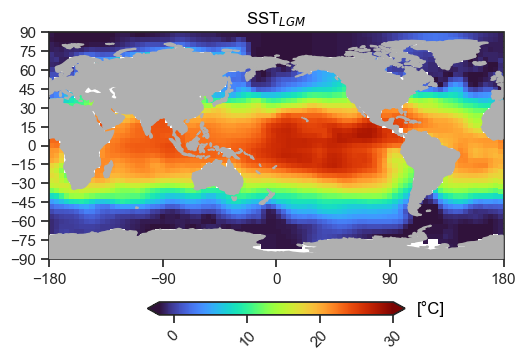

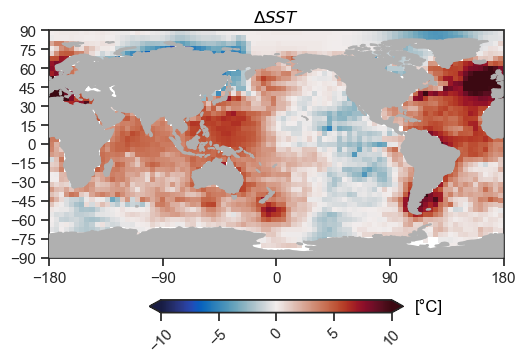

(Figure(<py Figure size 1500x500 with 2 Axes>), <py GeoAxes: title={'center': '$\\Delta SST $'}>)

In [8]:
plot_map_and_zonal(
  γ_lgm.lon, γ_lgm.lat,
  SST_LGM',
  SST_LGM_lat;
  map_norm    = matplotlib.colors.Normalize(vmin=-2, vmax=30),
  cmap        = "turbo",
  map_title   = "SST" * L"_{LGM}",
  cb_label    = "[°C]",
  zonal_xticks= -2:5:30,
  zonal_title = "Zonally Averaged\n" * "SST" * L"_{LGM}",
  savepath    = plotsdir("SST_LGM.png")
)

plot_map_and_zonal(
  γ_lgm.lon, γ_lgm.lat,
  ΔSST',
  ΔSST_lat;
  map_norm    = matplotlib.colors.Normalize(vmin=-10, vmax=10),
  cmap        = cm.balance,
  map_title   = L"\Delta SST ",
  cb_label    = "[°C]",
  zonal_xticks= -1:5,
  zonal_title = "Zonally Averaged\n" * L"\Delta" * "SST",
  savepath    = plotsdir("ΔSST.png")
)

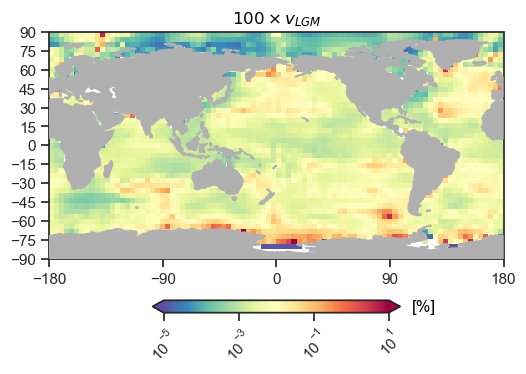

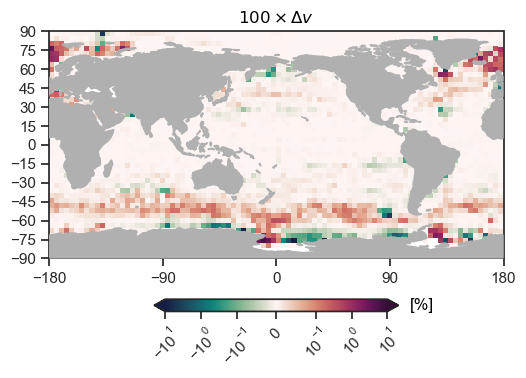

(Figure(<py Figure size 1500x500 with 2 Axes>), <py GeoAxes: title={'center': '$100 \\times \\Delta v$'}>)

In [9]:
plot_map_and_zonal(
  γ_lgm.lon, γ_lgm.lat,
  100 .* v_LGM',
  100 .* lgm_lat_volumes;
  map_norm    = matplotlib.colors.LogNorm(vmin=1e-5, vmax=1e1),
  cmap        = "Spectral_r",
  map_title   = L"100 \times v_{LGM}",
  cb_label    = "[%]",
  zonal_xticks= 0:10:45,
  zonal_title = "Zonally Summed\n" * L"100 \times v_{LGM}",
  savepath    = plotsdir("v_lgm_latitude.png")
)

plot_map_and_zonal(
  γ_lgm.lon, γ_lgm.lat,
  100 .* Δv',
  100 .* Δv_lat;
  map_norm    = matplotlib.colors.SymLogNorm(linthresh=1e-1, vmin=-1e1, vmax=1e1),
  cmap        = cm.curl,
  map_title   = L"100 \times \Delta v",
  cb_label    = "[%]",
  zonal_xticks= -30:15:30,
  zonal_title = "Zonally Summed\n" * L"100 \times \Delta v",
  savepath    = plotsdir("Δv_lgm_latitude.png")
)

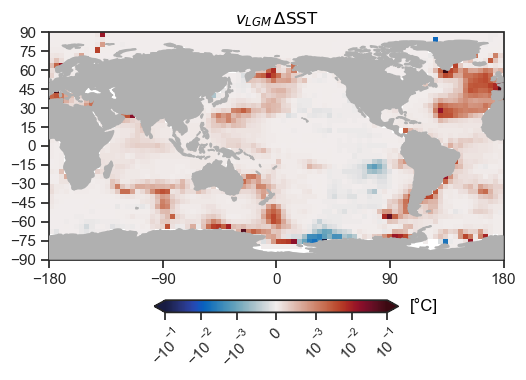

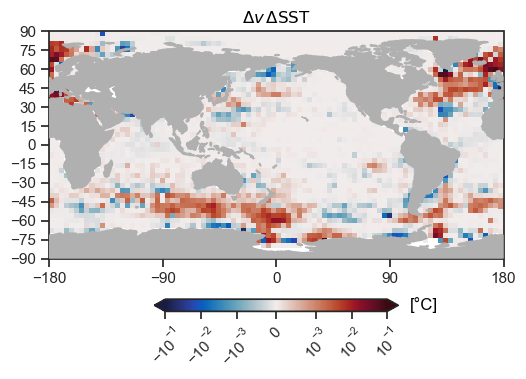

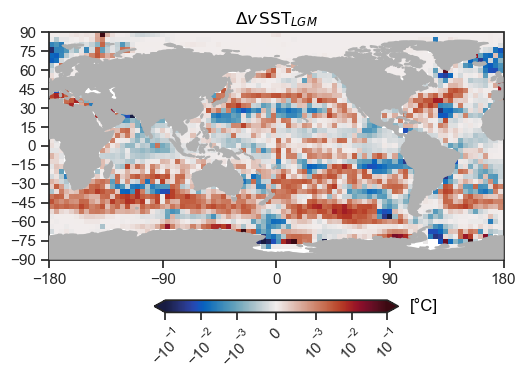

(Figure(<py Figure size 1500x500 with 2 Axes>), <py GeoAxes: title={'center': '$\\Delta v\\,\\mathrm{SST}_{LGM}$'}>)

In [11]:
norm =  matplotlib.colors.SymLogNorm(linthresh=1e-3, vmin=-1e-1, vmax=1e-1)

plot_map_and_zonal(
  γ_lgm.lon, γ_lgm.lat,
  ΔSST_vlgm', ΔSST_vlgm_lat;
  map_norm    =norm,
  cmap        = cm.balance,
  map_title   = L"v_{LGM}\,\Delta\mathrm{SST}",
  cb_label    = "[°C]",
  zonal_xticks= -0.3:0.15:0.3,
  zonal_title = "Zonally Summed\n" * L"v_{LGM} \Delta SST",
  savepath    = plotsdir("MOT_decomp_vLGM_ΔSST.png")
)

plot_map_and_zonal(
  γ_lgm.lon, γ_lgm.lat,
  ΔSST_Δv', ΔSST_Δv_lat;
  map_norm    =norm,
  cmap        = cm.balance,
  map_title   = L"\Delta v\,\Delta\mathrm{SST}",
  cb_label    = "[°C]",
  zonal_xticks= -0.3:0.15:0.3,
  zonal_title = "Zonally Summed\n" * L"\Delta v\, \Delta SST",
  savepath    = plotsdir("MOT_decomp_Δv_ΔSST.png")
)

plot_map_and_zonal(
  γ_lgm.lon, γ_lgm.lat,
  SSTlgm_Δv', SSTlgm_Δv_lat;
  map_norm    =norm,
  cmap        = cm.balance,
  map_title   = L"\Delta v\,\mathrm{SST}_{LGM}",
  cb_label    = "[°C]",
  zonal_xticks= -0.3:0.15:0.3,
  zonal_title = "Zonally Summed\n" * L"\Delta v\, \Delta SST",
  savepath    = plotsdir("MOT_decomp_Δv_SSTLGM.png")
)